python -m jupyter kernelspec list

In [1]:
import ast
import numpy as np
import math
import matplotlib.pyplot as plt
import h5py
from patient_functions.patient import Patient
from patient_functions.dvh import cumulative_dvh
from patient_functions.helpers import *
from patient_functions.two_beam import *

In [30]:
weights = [
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]]

costs = 10*np.array(weights)
min(np.asarray(costs).flatten())

1

In [2]:

patient_id = 'P23336'
pat = Patient(patient_id=patient_id, h5py_file_path=f'results/{patient_id}/{patient_id}_9_angles.h5')

In [23]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Example dataset
rng = np.random.RandomState(0)
data = rng.rand(5, 5)
print(data)
i = np.unravel_index(data.argmin(), data.shape)
data[i]

[[0.5488135  0.71518937 0.60276338 0.54488318 0.4236548 ]
 [0.64589411 0.43758721 0.891773   0.96366276 0.38344152]
 [0.79172504 0.52889492 0.56804456 0.92559664 0.07103606]
 [0.0871293  0.0202184  0.83261985 0.77815675 0.87001215]
 [0.97861834 0.79915856 0.46147936 0.78052918 0.11827443]]


0.02021839744032572

In [3]:
pat.gaze_angle_keys[1]
angle_1 = '(0, 0)'
angle_2 = '(25, 0)'

In [4]:
pat.two_beams(gaze_angle_keys=(angle_1, angle_2), weight=0.5)

TypeError: 'bool' object is not callable

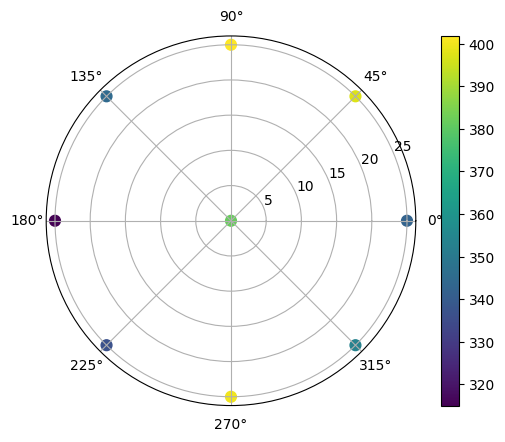

In [6]:
metric = 'volume_term'

#metric=convert_metric(metric)
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
sc = pat.single_gaze_plot(ax, metric)
plt.colorbar(sc, ax=ax, fraction=0.05)
plt.show()


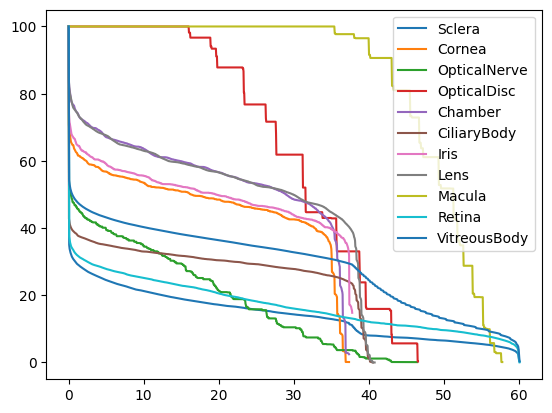

In [10]:
fig, ax = plt.subplots()
for roi in pat.roi_names:

    pat.gaze_angle_dvhs['(0, 0)'].roi_dvhs[roi].plot(ax, {'label': roi})

plt.legend()

    

In [ ]:
pat.gaze_angle_dvhs['(0, 0)'].roi_dvhs['Macula'].get_dvh_auc()/100

In [ ]:
pat.roi_names

In [ ]:
filters = [
    {'roi_name': 'Macula', 'filter_type': 'D', 'value': 90, 'max_val': 40},
    {'roi_name': 'Lens', 'filter_type': 'V', 'value': 10, 'max_val': 1}
    ]

In [ ]:
filtered_gaze_angles=pat.apply_dvh_filters(filters)
print(filtered_gaze_angles)

In [ ]:
for roi_name in pat.roi_names:
    fig, ax = plt.subplots()
    for angle in pat.gaze_angle_keys:
        if angle not in filtered_gaze_angles:
            pat.gaze_angle_dvhs[angle].roi_dvhs[roi_name].plot(ax=ax, plot_args = {'color': 'gray'})
        else:
            pat.gaze_angle_dvhs[angle].roi_dvhs[roi_name].plot(ax=ax)
        plt.grid()
        plt.title(roi_name)